In [159]:
from visual_behavior.data_access import loading
import visual_behavior.utilities as vbu
import visual_behavior.plotting as vbp
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns
from scipy import stats
import itertools

from visual_behavior.visualization import utils as vis_utils

import allensdk.brain_observatory.behavior.behavior_project_cache as bpc

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# choose a location on your file system to cache NWB files as they are loaded:
my_cache_dir = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/visual_behavior_production_analysis/'

# bc = bpc.VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=my_cache_dir)
bc = bpc.VisualBehaviorOphysProjectCache.from_lims(data_release_date='2021-03-25')
          
behavior_session_table = bc.get_behavior_session_table().sort_values(by = ['mouse_id', 'date_of_acquisition'])

# NOTE: behavior_session_id 944971315 was an OPHYS_0 session that was run out of order. Dropping it to avoid messing up time-to-stage statistics
behavior_session_table.drop(index = 944971315, inplace=True)

In [4]:
behavior_session_table['session_type_simple'] = behavior_session_table['session_type'].map(lambda st: st.split('_')[0] + '_' + st.split('_')[1])

In [5]:
np.sort(behavior_session_table['session_type_simple'].unique())

array(['OPHYS_0', 'OPHYS_1', 'OPHYS_2', 'OPHYS_3', 'OPHYS_4', 'OPHYS_5',
       'OPHYS_6', 'TRAINING_0', 'TRAINING_1', 'TRAINING_2', 'TRAINING_3',
       'TRAINING_4', 'TRAINING_5'], dtype=object)

In [6]:
session_types_of_interest = ['OPHYS_3', 'OPHYS_4']
sessions_to_analyze = behavior_session_table.query('session_type_simple in @session_types_of_interest and prior_exposures_to_session_type == 0')
sessions_to_analyze = sessions_to_analyze[pd.notnull(sessions_to_analyze['ophys_session_id'])]

In [7]:
len(sessions_to_analyze)

127

In [19]:
def get_event_triggered_dataframes(session):
    et = session.extended_trials
    engaged_change_times = et.query('go and engaged')['change_time']

    esp = session.extended_stimulus_presentations
    engaged_omission_times = esp.query('omitted and engaged')['start_time']

    change_triggered_pupil = vbu.event_triggered_response(df = session.eye_tracking, parameter = 'pupil_area', event_times = engaged_change_times, time_key = 'timestamps')
    change_triggered_running = vbu.event_triggered_response(df = session.running_speed, parameter = 'speed', event_times = engaged_change_times, time_key = 'timestamps')

    omission_triggered_pupil = vbu.event_triggered_response(df = session.eye_tracking, parameter = 'pupil_area', event_times = engaged_omission_times, time_key = 'timestamps')
    omission_triggered_running = vbu.event_triggered_response(df = session.running_speed, parameter = 'speed', event_times = engaged_omission_times, time_key = 'timestamps')
        
    return change_triggered_pupil, change_triggered_running, omission_triggered_pupil, omission_triggered_running

def get_pupil_and_running(ophys_experiment_id):
    try:
        session = loading.get_ophys_dataset(ophys_experiment_id)
        
        change_triggered_pupil, change_triggered_running, omission_triggered_pupil, omission_triggered_running = get_event_triggered_dataframes(session)
        
        data_to_return = {
            ophys_experiment_id: {
                'change_triggered_pupil': change_triggered_pupil.groupby('time')[['pupil_area']].mean().reset_index().to_dict(),
                'omission_triggered_pupil': omission_triggered_pupil.groupby('time')[['pupil_area']].mean().reset_index().to_dict(),
                'change_triggered_running': change_triggered_running.groupby('time')[['speed']].mean().reset_index().to_dict(),
                'omission_triggered_running': omission_triggered_running.groupby('time')[['speed']].mean().reset_index().to_dict(),
            }
        }
    except Exception as e:
        print(e)
        data_to_return = None

    return data_to_return

In [20]:
ophys_experiment_id = 853363739
data = get_pupil_and_running(ophys_experiment_id)

<IPython.core.display.Javascript object>


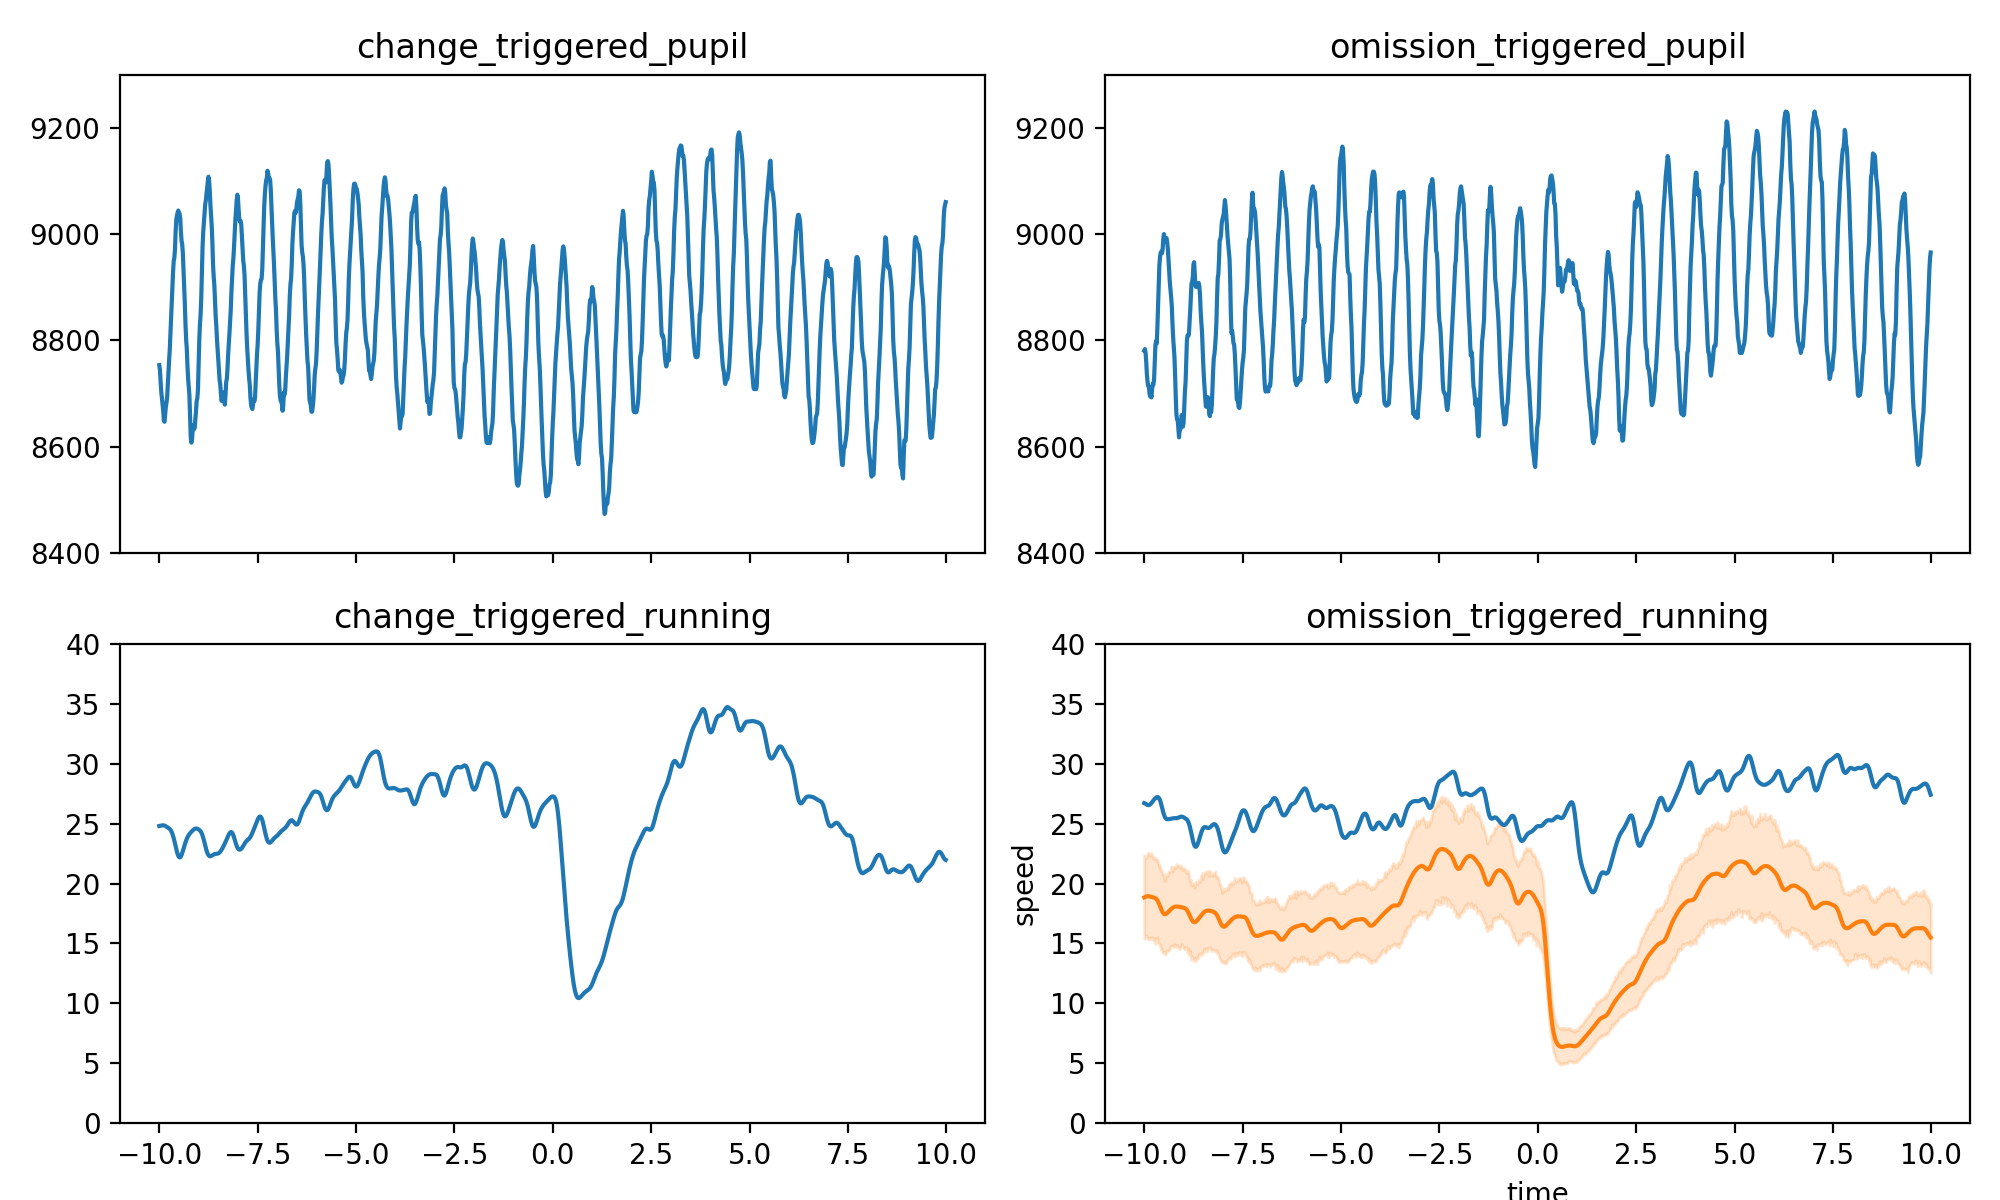

In [21]:
fig, ax = plt.subplots(2,2,sharex=True, figsize = (10,6))
change_triggered_pupil = pd.DataFrame(data[853363739]['change_triggered_pupil'])
ax[0,0].plot(change_triggered_pupil['time'], change_triggered_pupil['pupil_area'])
ax[0,0].set_title('change_triggered_pupil')
ax[0, 0].set_ylim(8400, 9300)

omission_triggered_pupil = pd.DataFrame(data[853363739]['omission_triggered_pupil'])
ax[0,1].plot(omission_triggered_pupil['time'], omission_triggered_pupil['pupil_area'])
ax[0,1].set_title('omission_triggered_pupil')
ax[0, 1].set_ylim(8400, 9300)

change_triggered_running = pd.DataFrame(data[853363739]['change_triggered_running'])
ax[1, 0].plot(change_triggered_running['time'], change_triggered_running['speed'])
ax[1, 0].set_title('change_triggered_running')
ax[1, 0].set_ylim(0,40)

omission_triggered_running = pd.DataFrame(data[853363739]['omission_triggered_running'])
ax[1, 1].plot(omission_triggered_running['time'], omission_triggered_running['speed'])
ax[1, 1].set_title('omission_triggered_running')
ax[1,1].set_ylim(0,40)

fig.tight_layout()

In [22]:
with Pool(28) as pool:
    all_data = pool.map(
        get_pupil_and_running,
        sessions_to_analyze['ophys_experiment_id'].map(lambda oeids: oeids[0]).values
    )

model outputs not available
model outputs not available
"None of [Index(['engaged', 'engagement_state'], dtype='object')] are in the [columns]"
model outputs not available


model outputs not available


model outputs not available


model outputs not available
"None of [Index(['engaged', 'engagement_state'], dtype='object')] are in the [columns]"
"None of [Index(['engaged', 'engagement_state'], dtype='object')] are in the [columns]"


model outputs not available


model outputs not available
model outputs not available


"None of [Index(['engaged', 'engagement_state'], dtype='object')] are in the [columns]"


model outputs not available


"None of [Index(['engaged', 'engagement_state'], dtype='object')] are in the [columns]"


model outputs not available


model outputs not available
Error! The number of sync file frame times (135924) does not match the number of eye tracking frames (135928)!


"None of [Index(['engaged', 'engagement_state'], dtype='object')] are in the [columns]"


model outputs not available


model outputs not available
"None of [Index(['engaged', 'engagement_state'], dtype='object')] are in the [columns]"


model outputs not available


model outputs not available


"None of [Index(['engaged', 'engagement_state'], dtype='object')] are in the [columns]"


In [57]:
# convert the list of dicts into a dict with oeid ask key
all_data_dict = {list(data.keys())[0]:data[list(data.keys())[0]] for data in all_data if pd.notnull(data)}

In [87]:
session_types = ['OPHYS_3', 'OPHYS_4']
plots_to_make = ['change_triggered_pupil', 'omission_triggered_pupil', 'change_triggered_running', 'omission_triggered_running']

dfs = {}
for session_type in session_types:
    dfs[session_type] = {}

for session_type in session_types:
    oeids = sessions_to_analyze.query('session_type_simple == @session_type')['ophys_experiment_id'].map(lambda oeids: oeids[0]).values
    for plot_to_make in plots_to_make:
        dfs[session_type][plot_to_make] = []
        for oeid in oeids:
            if oeid in list(all_data_dict.keys()):
                df = pd.DataFrame(all_data_dict[oeid][plot_to_make])
                df['ophys_experiment_id'] = oeid
                dfs[session_type][plot_to_make].append(df)
        dfs[session_type][plot_to_make] = pd.concat(dfs[session_type][plot_to_make])

In [90]:
dfs['OPHYS_3']['change_triggered_running']

time      speed  ophys_experiment_id
0    -10.000000  34.223972            795073741
1     -9.983333  34.251522            795073741
2     -9.966667  34.293968            795073741
3     -9.950000  34.347335            795073741
4     -9.933333  34.413925            795073741
...         ...        ...                  ...
1195   9.916667  23.105254           1059963010
1196   9.933333  22.879789           1059963010
1197   9.950000  22.630965           1059963010
1198   9.966667  22.370456           1059963010
1199   9.983333  22.111280           1059963010

[68400 rows x 3 columns]

In [99]:
row

2

<IPython.core.display.Javascript object>


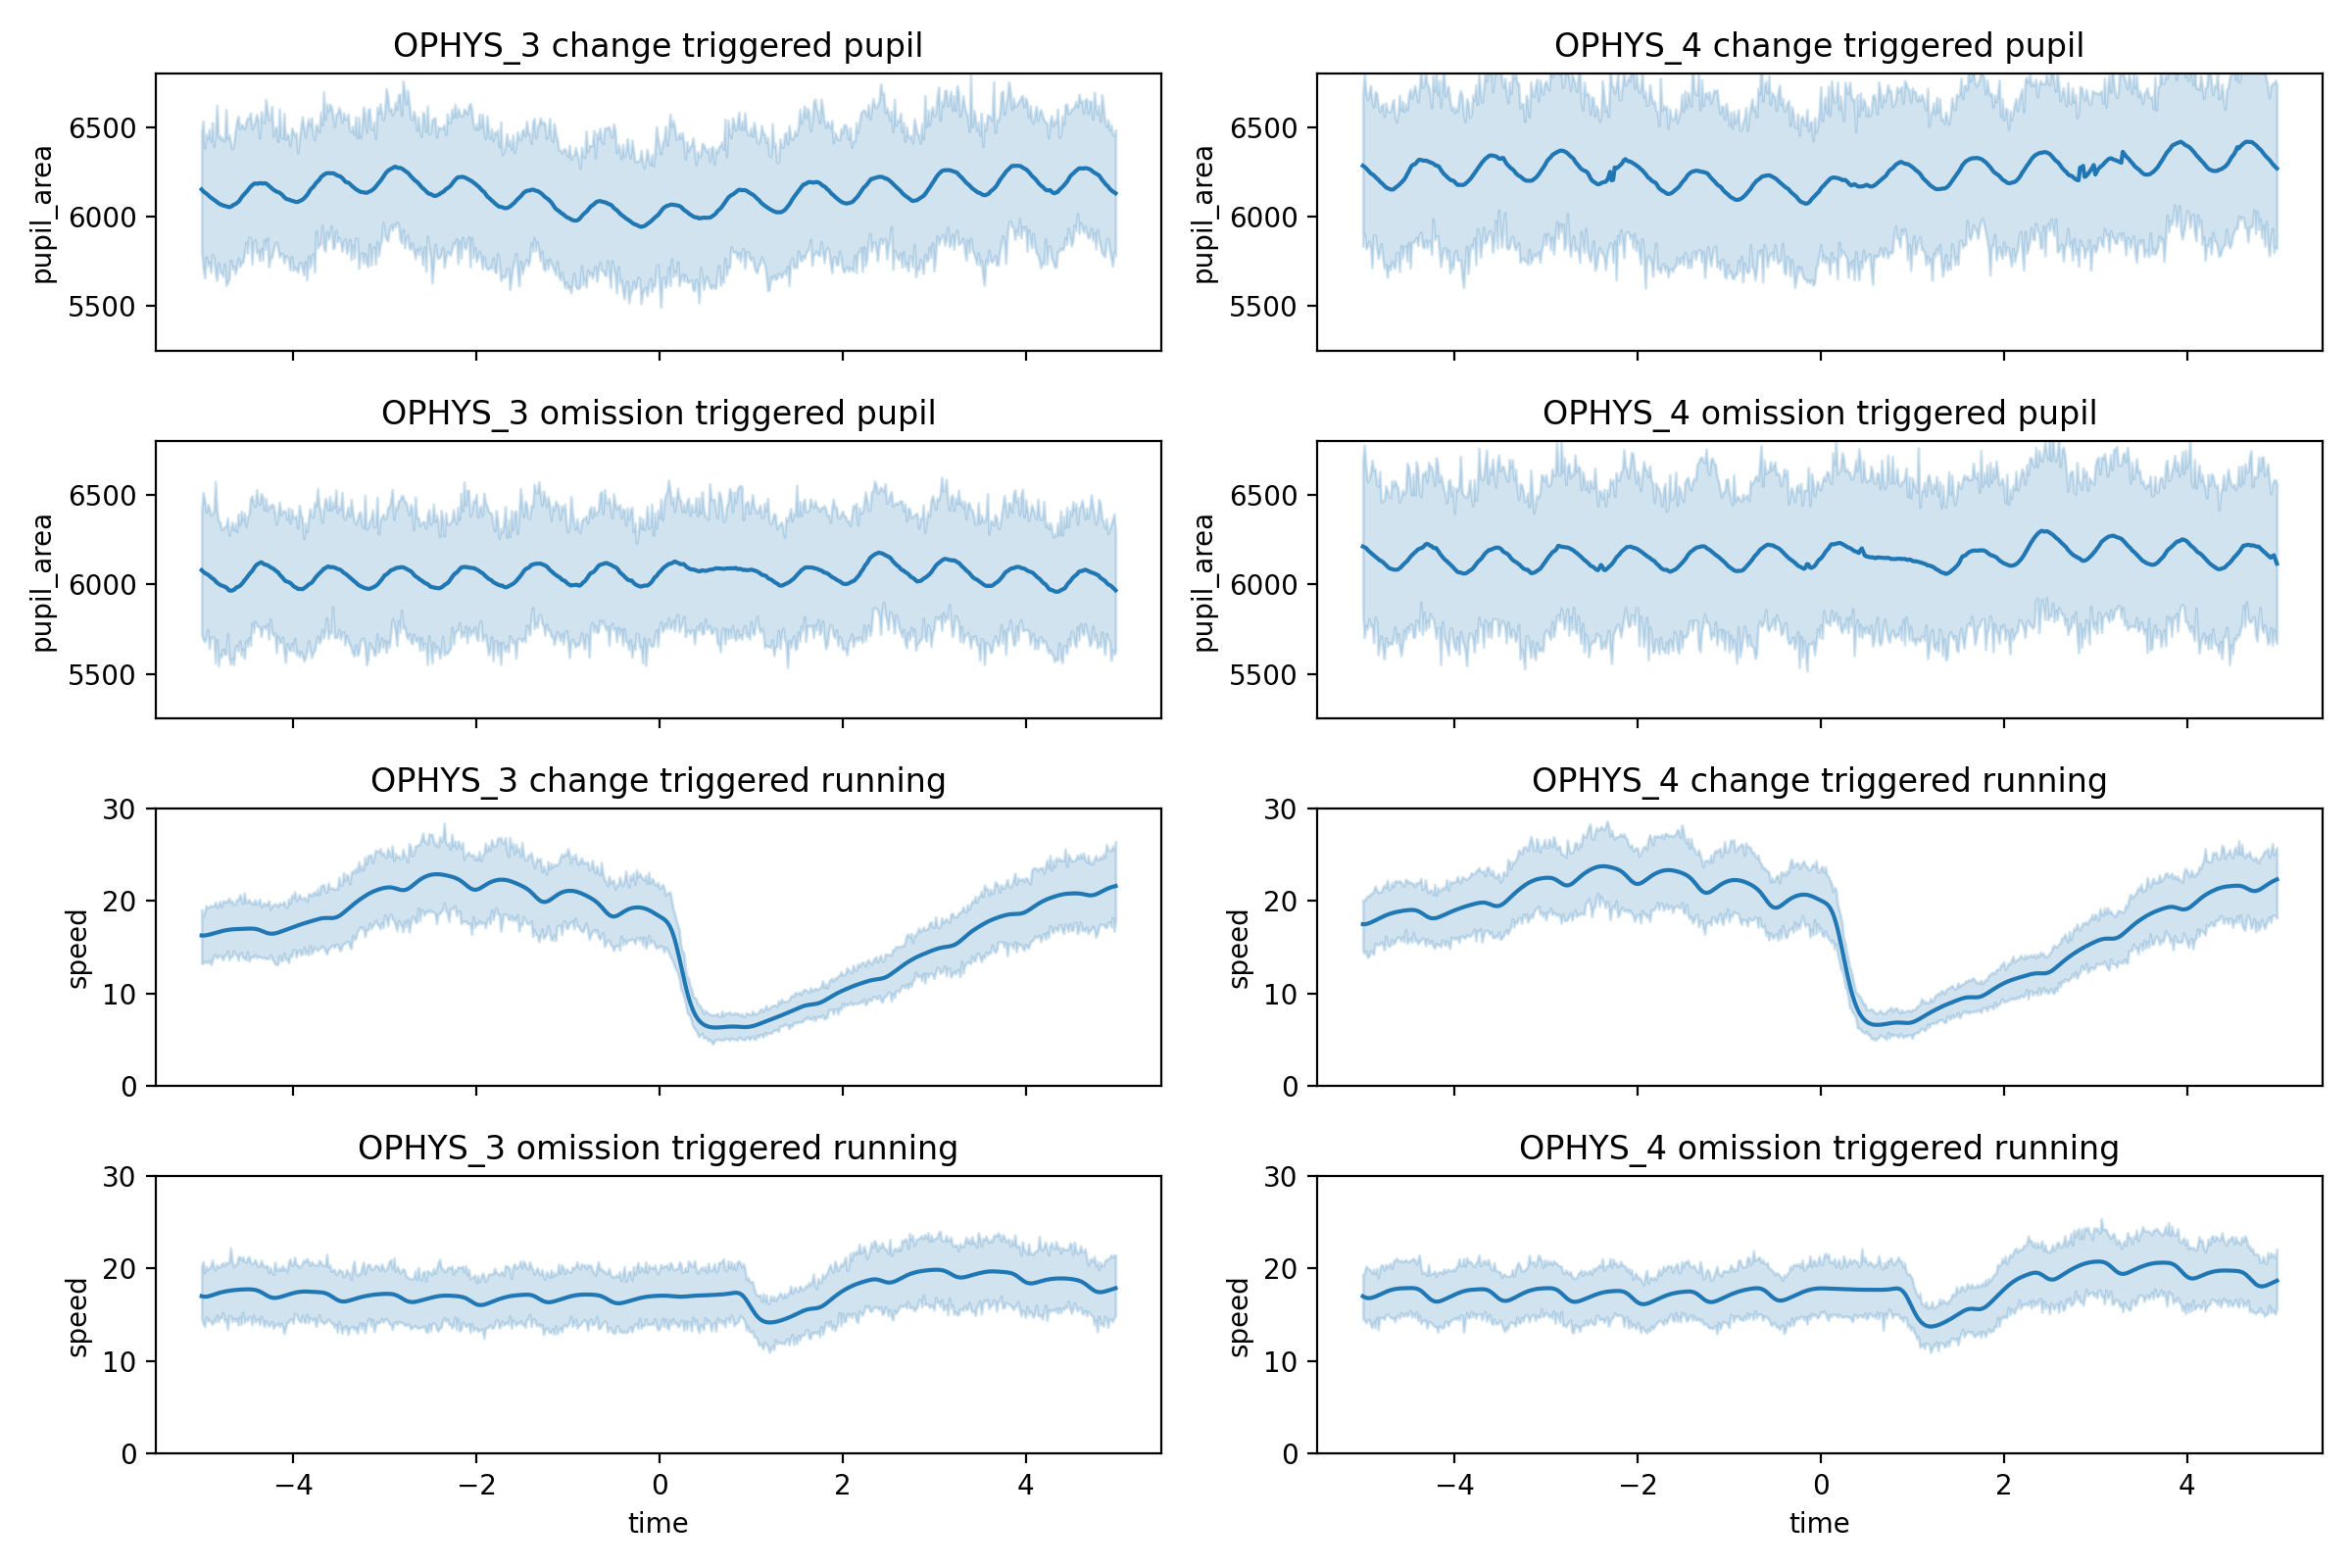

In [144]:
fig, ax = plt.subplots(4,2,figsize=(12,8), sharex=True)
for col, session_type in enumerate(session_types):
    oeids = sessions_to_analyze.query('session_type_simple == @session_type')['ophys_experiment_id'].map(lambda oeids: oeids[0]).values
    for row, plot_to_make in enumerate(plots_to_make):
        if 'pupil' in plot_to_make:
            y = 'pupil_area'
            # filter out the really big pupil values, which are likely erroneous
            data = dfs[session_type][plot_to_make].query('pupil_area < 10000 and time > -5 and time < 5')
            ylim =(5250, 6800)
        elif 'running' in plot_to_make:
            y = 'speed'
            data = dfs[session_type][plot_to_make].query('time > -5 and time < 5')
            ylim = (0, 30)
        sns.lineplot(
            data = data,
            x = 'time',
            y = y,
            ax = ax[row, col],
            n_boot = 100
        )
        ax[row, col].set_ylim(ylim[0], ylim[1])
        ax[row, col].set_title('{} {}'.format(session_type, plot_to_make.replace('_',' ')))

fig.tight_layout()

<IPython.core.display.Javascript object>


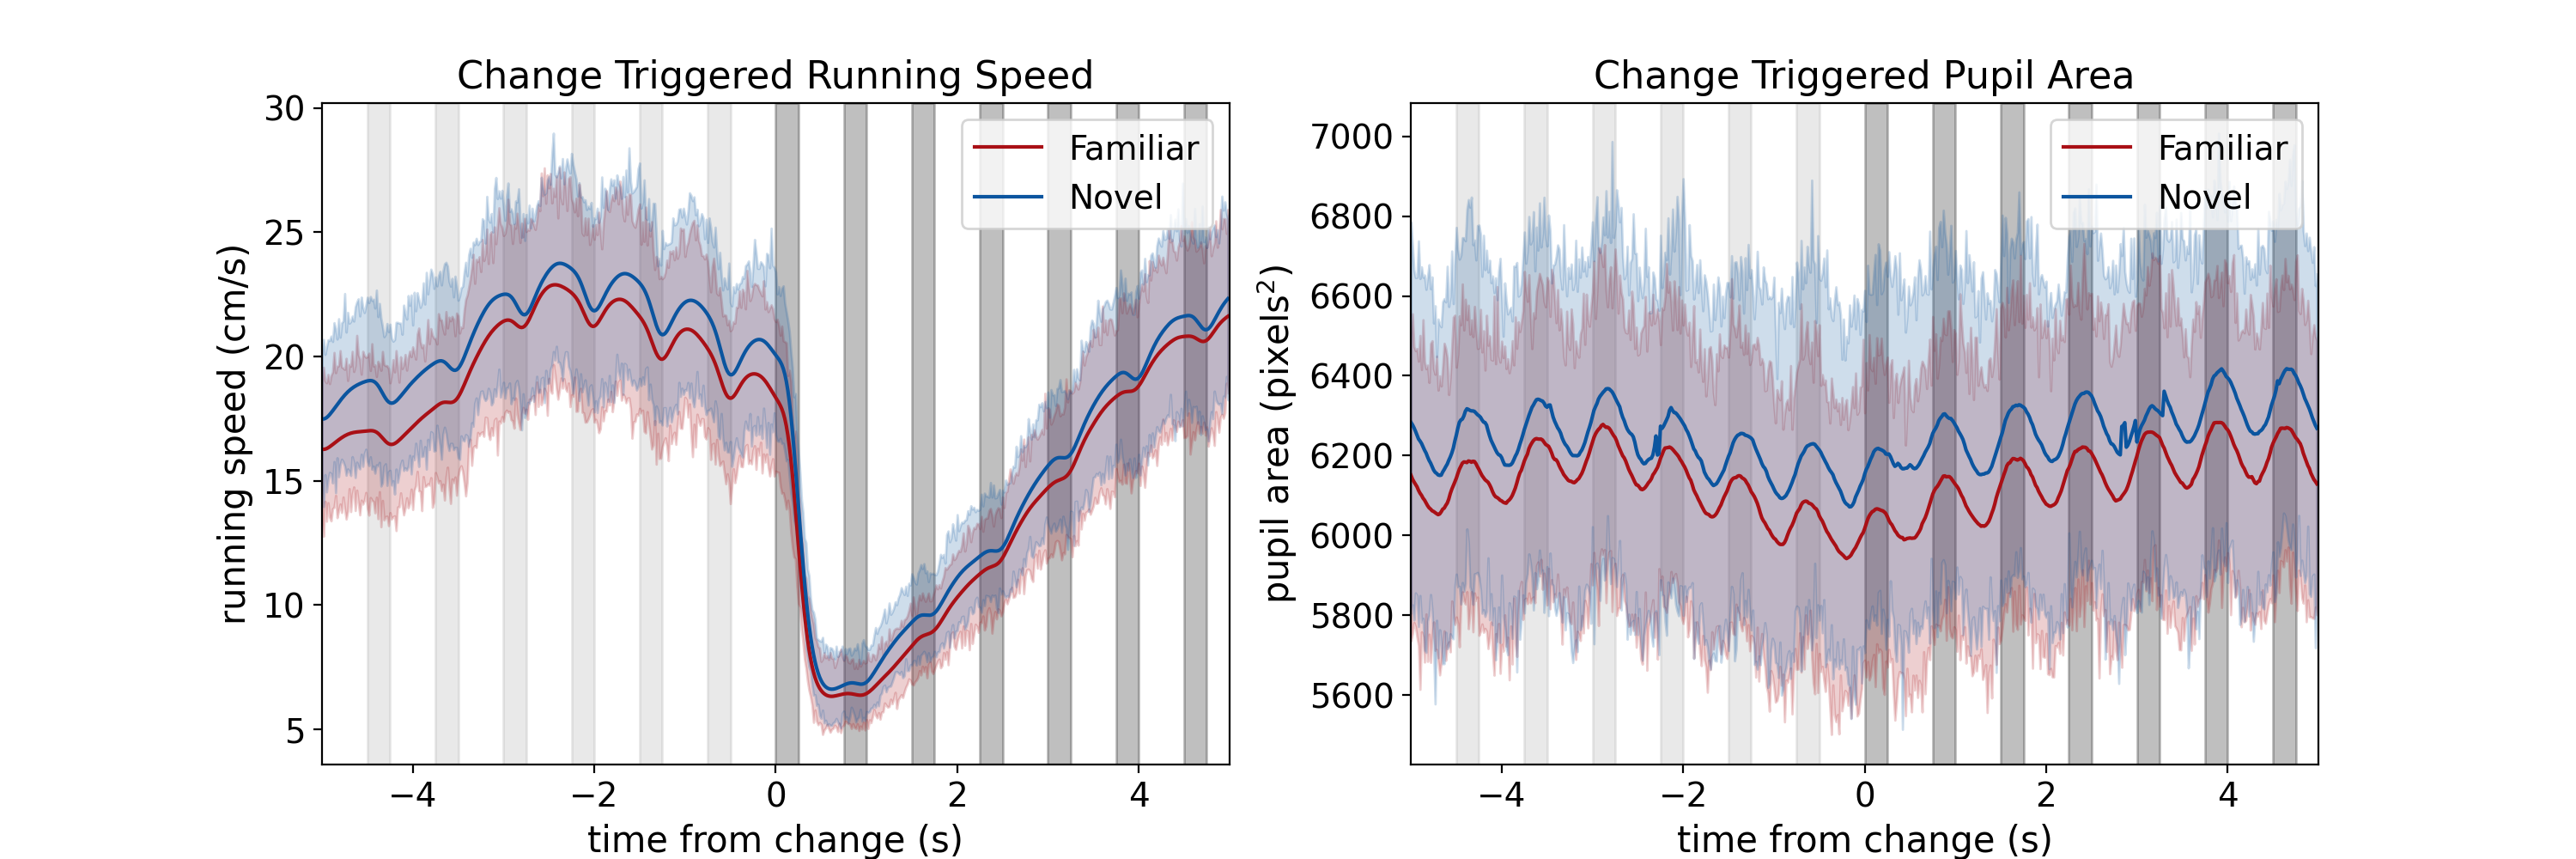

In [223]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.lineplot(
    data = dfs['OPHYS_3']['change_triggered_running'].query('time > -5 and time < 5'),
    x = 'time',
    y = 'speed',
    ax = ax[0],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_1_images_A']/255
)

sns.lineplot(
    data = dfs['OPHYS_4']['change_triggered_running'].query('time > -5 and time < 5'),
    x = 'time',
    y = 'speed',
    ax = ax[0],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_4_images_B']/255
)

ax[0].legend(['Familiar','Novel'], fontsize = 14, loc = 'upper right')
ax[0].set_xlabel('time from change (s)')
ax[0].set_ylabel('running speed (cm/s)')
ax[0].set_xlim(-5,5)
vbp.designate_flashes(ax[0], omit=None, pre_color='darkgray', post_color='black')
ax[0].set_title('Change Triggered Running Speed')


sns.lineplot(
    data = dfs['OPHYS_3']['change_triggered_pupil'].query('pupil_area < 10000 and time > -5 and time < 5'),
    x = 'time',
    y = 'pupil_area',
    ax = ax[1],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_1_images_A']/255
)

sns.lineplot(
    data = dfs['OPHYS_4']['change_triggered_pupil'].query('pupil_area < 10000 and time > -5 and time < 5'),
    x = 'time',
    y = 'pupil_area',
    ax = ax[1],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_4_images_B']/255
)

ax[1].legend(['Familiar','Novel'], fontsize = 14, loc = 'upper right')
ax[1].set_xlabel('time from change (s)')
ax[1].set_ylabel('pupil area (pixels$^2$)')
ax[1].set_xlim(-5,5)
vbp.designate_flashes(ax[1], omit=None, pre_color='darkgray', post_color='black')
ax[1].set_title('Change Triggered Pupil Area')

for axis in ax:
    axis.set_title(axis.get_title(), fontsize = 16)
    for tick in axis.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    axis.set_ylabel(axis.get_ylabel(), fontsize=15)
    axis.set_xlabel(axis.get_xlabel(), fontsize=15)

<IPython.core.display.Javascript object>


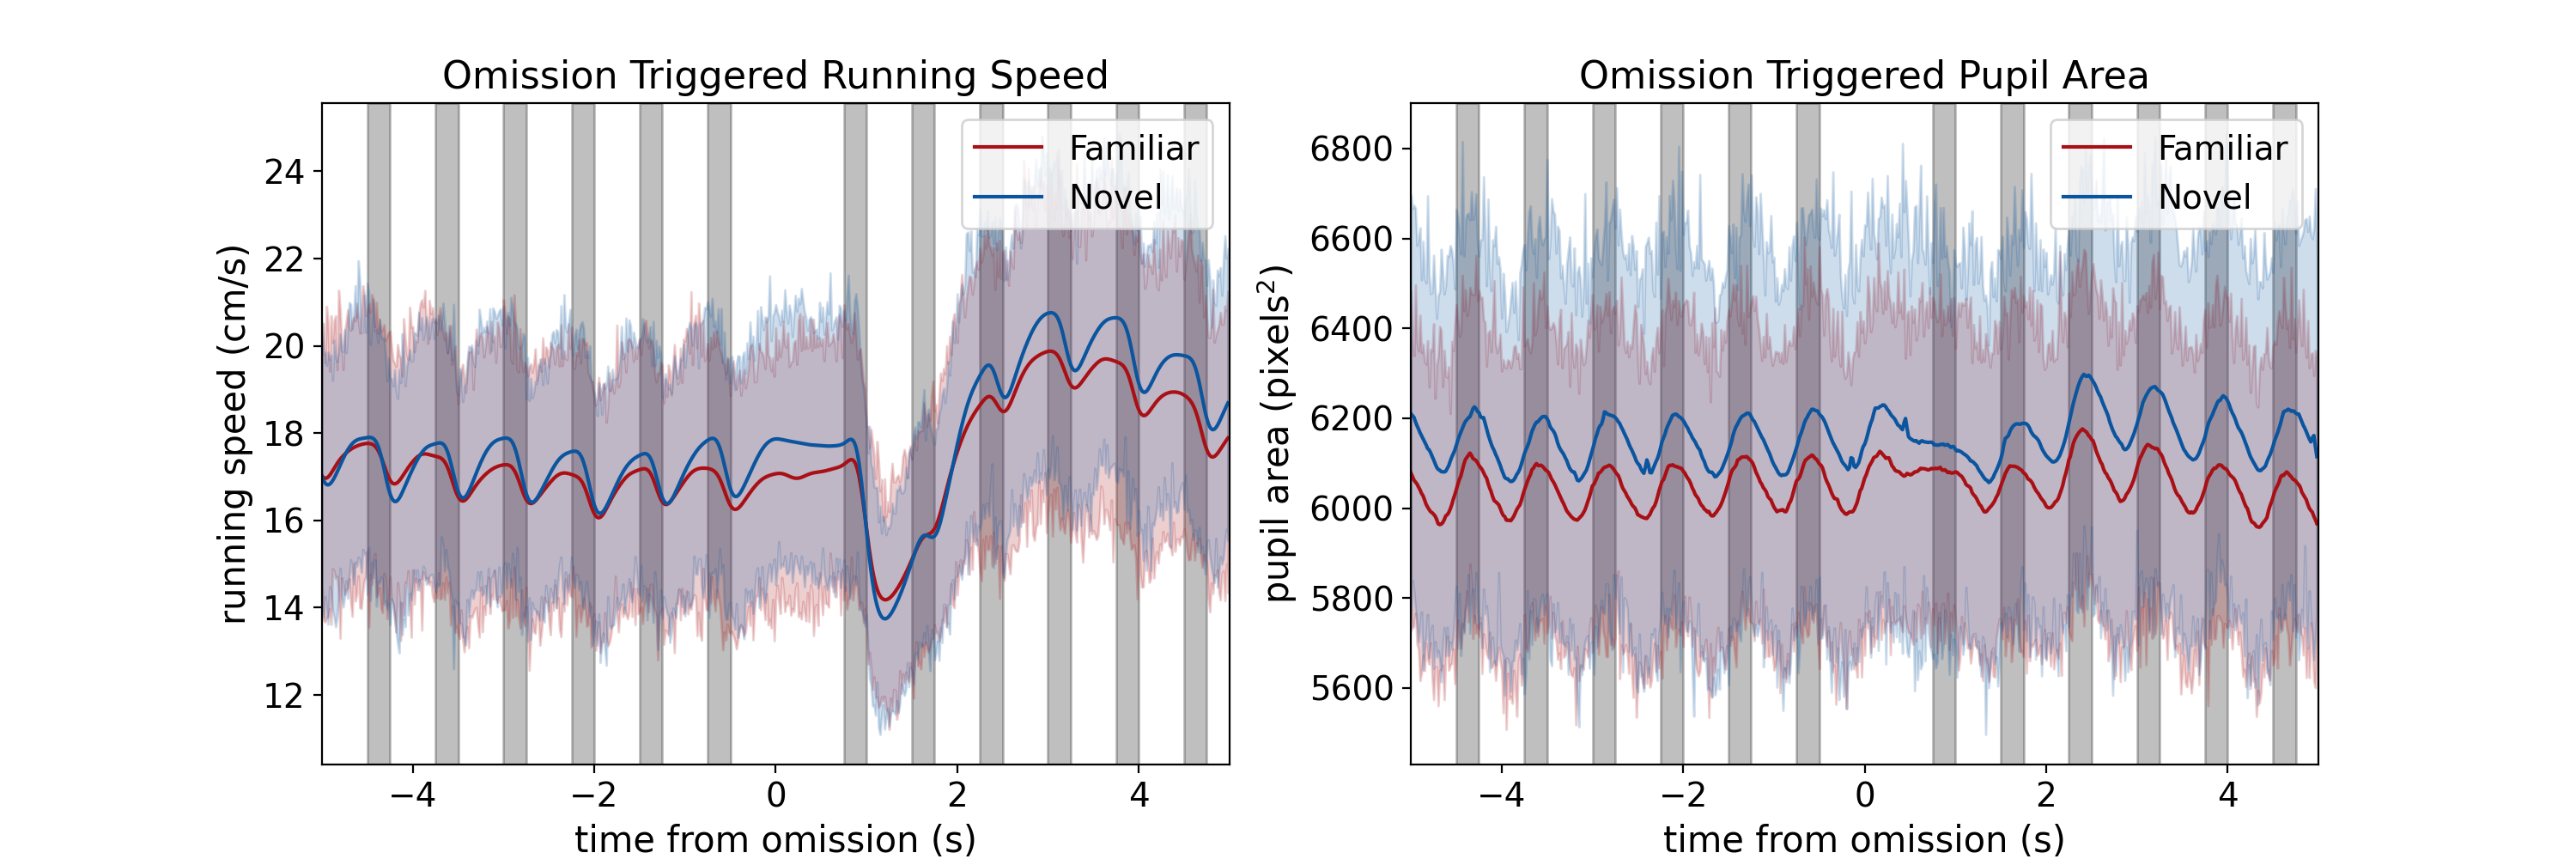

In [222]:
fig, ax = plt.subplots(1,2,figsize = (15,5))
sns.lineplot(
    data = dfs['OPHYS_3']['omission_triggered_running'].query('time > -5 and time < 5'),
    x = 'time',
    y = 'speed',
    ax = ax[0],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_1_images_A']/255
)

sns.lineplot(
    data = dfs['OPHYS_4']['omission_triggered_running'].query('time > -5 and time < 5'),
    x = 'time',
    y = 'speed',
    ax = ax[0],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_4_images_B']/255
)

ax[0].legend(['Familiar','Novel'], fontsize = 14, loc = 'upper right')
ax[0].set_xlabel('time from omission (s)')
ax[0].set_ylabel('running speed (cm/s)')
ax[0].set_xlim(-5,5)
vbp.designate_flashes(ax[0], omit=0, pre_color='black', post_color='black')
ax[0].set_title('Omission Triggered Running Speed')


sns.lineplot(
    data = dfs['OPHYS_3']['omission_triggered_pupil'].query('pupil_area < 10000 and time > -5 and time < 5'),
    x = 'time',
    y = 'pupil_area',
    ax = ax[1],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_1_images_A']/255
)

sns.lineplot(
    data = dfs['OPHYS_4']['omission_triggered_pupil'].query('pupil_area < 10000 and time > -5 and time < 5'),
    x = 'time',
    y = 'pupil_area',
    ax = ax[1],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_4_images_B']/255
)

ax[1].legend(['Familiar','Novel'], fontsize = 14, loc = 'upper right')
ax[1].set_xlabel('time from omission (s)')
ax[1].set_ylabel('pupil area (pixels$^2$)')
ax[1].set_xlim(-5,5)
vbp.designate_flashes(ax[1], omit=0, pre_color='black', post_color='black')
ax[1].set_title('Omission Triggered Pupil Area')

for axis in ax:
    axis.set_title(axis.get_title(), fontsize = 16)
    for tick in axis.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    axis.set_ylabel(axis.get_ylabel(), fontsize=15)
    axis.set_xlabel(axis.get_xlabel(), fontsize=15)

<IPython.core.display.Javascript object>


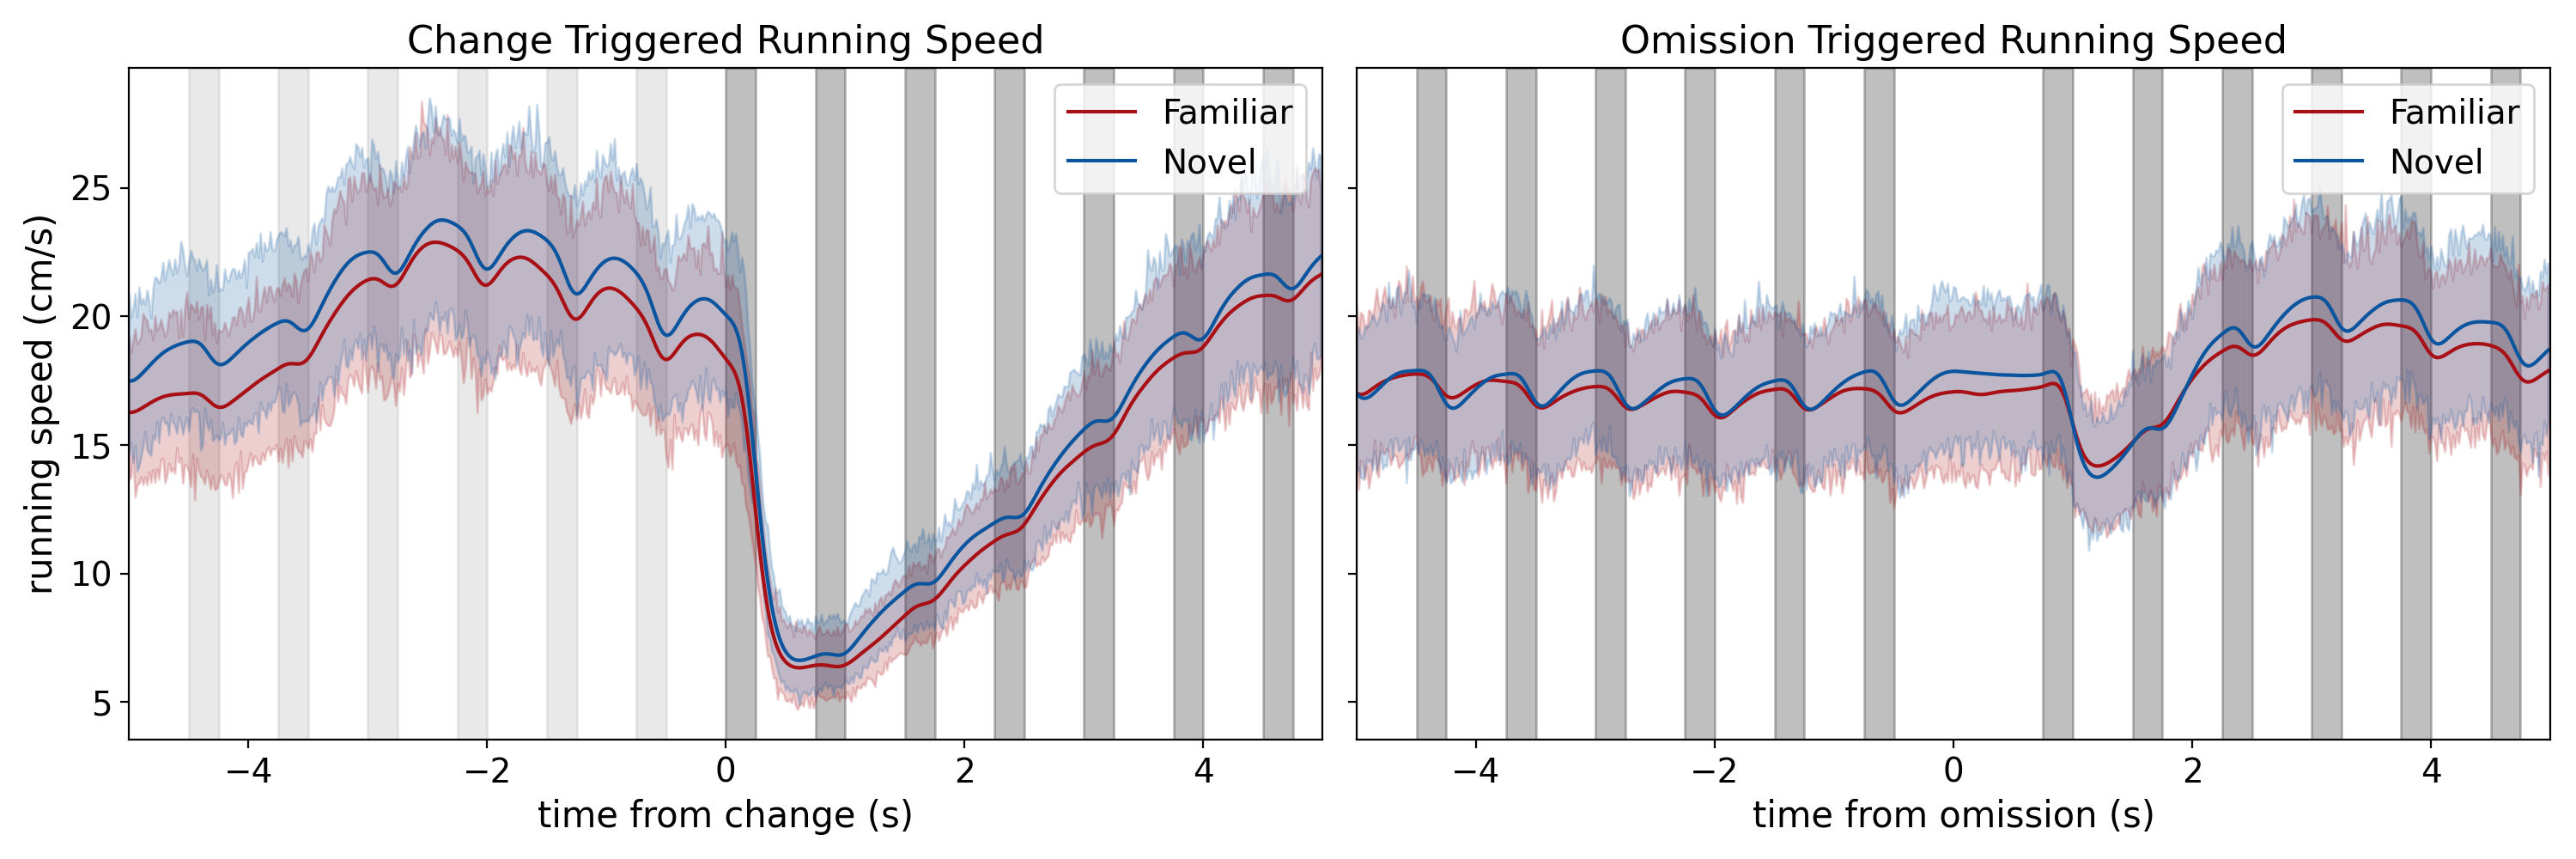

In [218]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)
sns.lineplot(
    data = dfs['OPHYS_3']['change_triggered_running'].query('time > -5 and time < 5'),
    x = 'time',
    y = 'speed',
    ax = ax[0],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_1_images_A']/255
)

sns.lineplot(
    data = dfs['OPHYS_4']['change_triggered_running'].query('time > -5 and time < 5'),
    x = 'time',
    y = 'speed',
    ax = ax[0],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_4_images_B']/255
)

ax[0].legend(['Familiar','Novel'], fontsize = 14, loc = 'upper right')
ax[0].set_xlabel('time from change (s)')
ax[0].set_ylabel('running speed (cm/s)')
ax[0].set_xlim(-5,5)
vbp.designate_flashes(ax[0], omit=None, pre_color='darkgray', post_color='black')
ax[0].set_title('Change Triggered Running Speed')

sns.lineplot(
    data = dfs['OPHYS_3']['omission_triggered_running'].query('time > -5 and time < 5'),
    x = 'time',
    y = 'speed',
    ax = ax[1],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_1_images_A']/255
)

sns.lineplot(
    data = dfs['OPHYS_4']['omission_triggered_running'].query('time > -5 and time < 5'),
    x = 'time',
    y = 'speed',
    ax = ax[1],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_4_images_B']/255
)

ax[1].legend(['Familiar','Novel'], fontsize = 14, loc = 'upper right')
ax[1].set_xlabel('time from omission (s)')
ax[1].set_ylabel('running speed (cm/s)')
ax[1].set_xlim(-5,5)
vbp.designate_flashes(ax[1], omit=0, pre_color='black', post_color='black')
ax[1].set_title('Omission Triggered Running Speed')

for axis in ax:
    axis.set_title(axis.get_title(), fontsize = 16)
    for tick in axis.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    axis.set_ylabel(axis.get_ylabel(), fontsize=15)
    axis.set_xlabel(axis.get_xlabel(), fontsize=15)

fig.tight_layout()

<IPython.core.display.Javascript object>


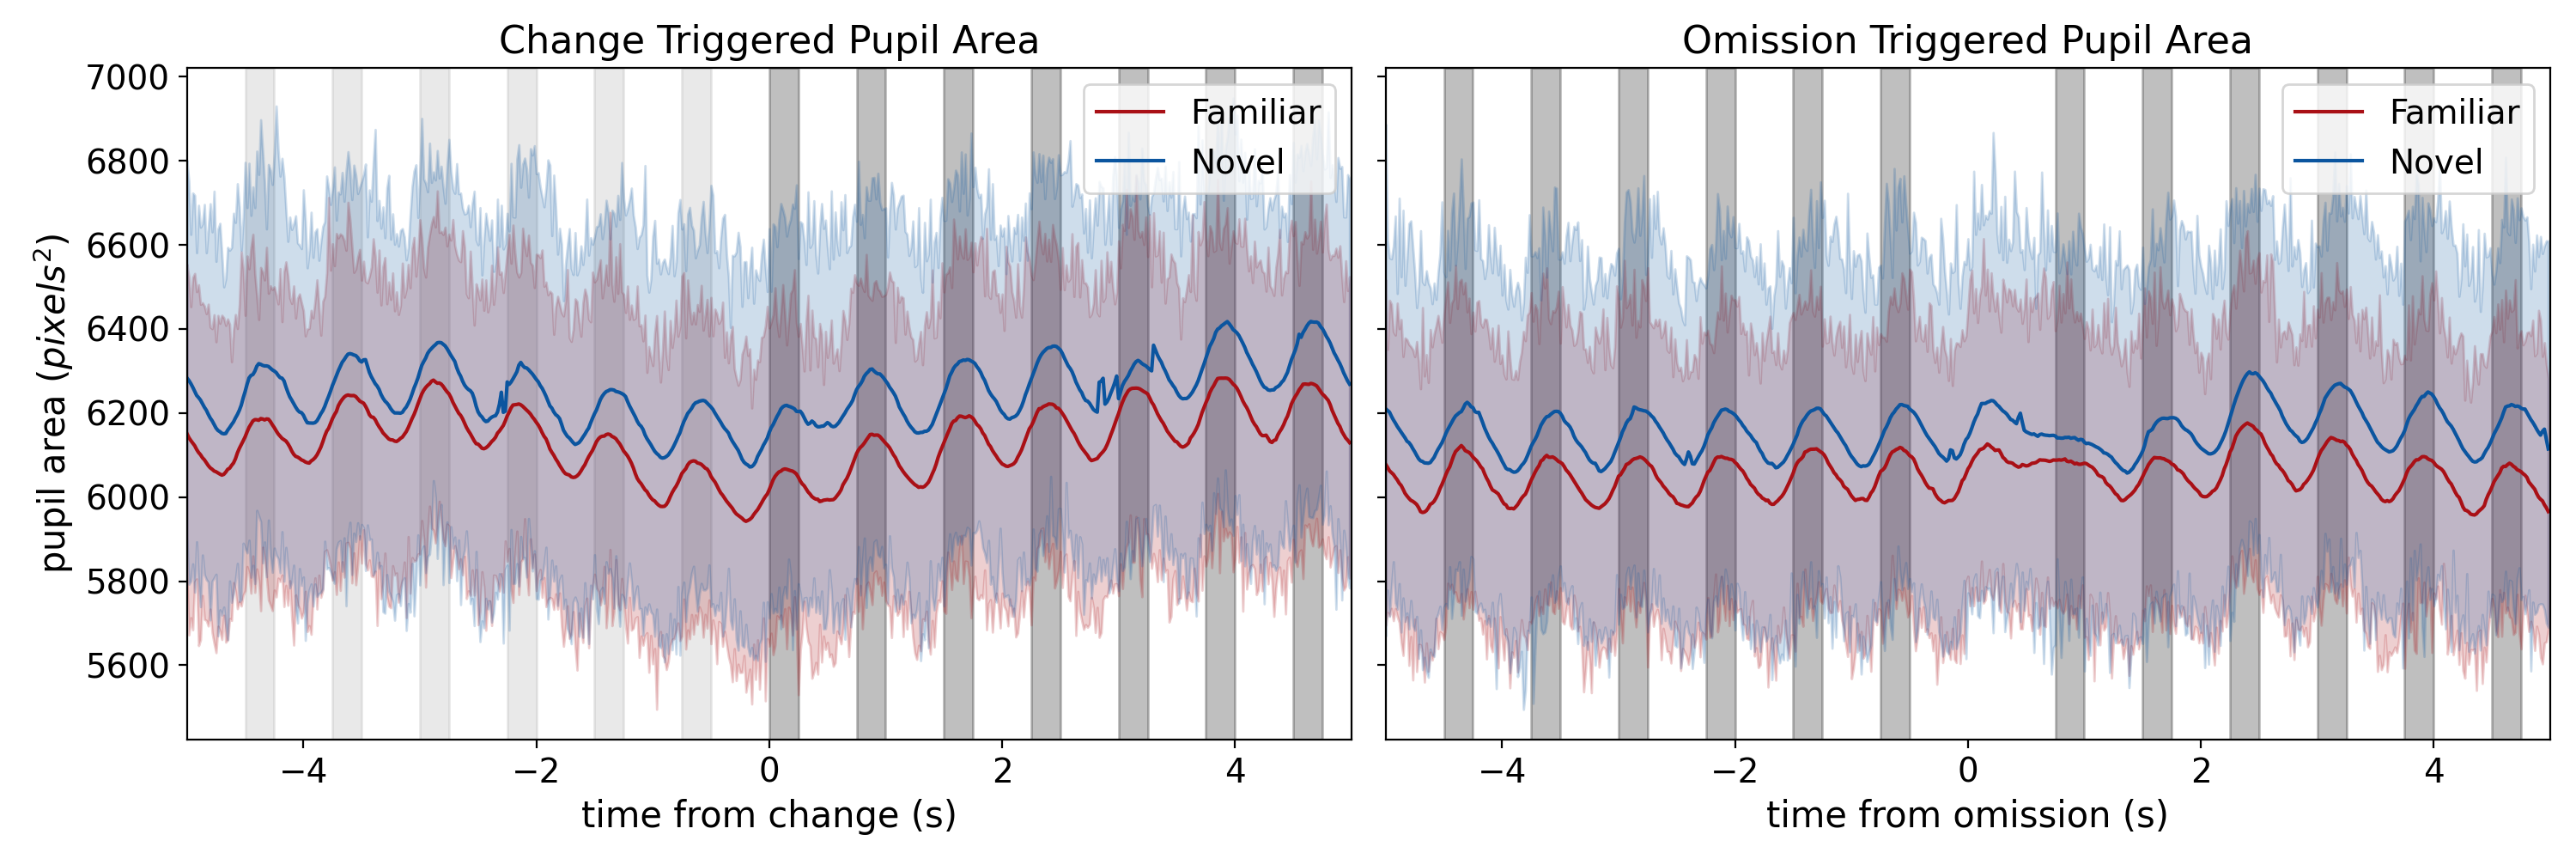

In [217]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharey=True)

sns.lineplot(
    data = dfs['OPHYS_3']['change_triggered_pupil'].query('pupil_area < 10000 and time > -5 and time < 5'),
    x = 'time',
    y = 'pupil_area',
    ax = ax[0],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_1_images_A']/255
)

sns.lineplot(
    data = dfs['OPHYS_4']['change_triggered_pupil'].query('pupil_area < 10000 and time > -5 and time < 5'),
    x = 'time',
    y = 'pupil_area',
    ax = ax[0],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_4_images_B']/255
)

ax[0].legend(['Familiar','Novel'], fontsize = 14, loc = 'upper right')
ax[0].set_xlabel('time from change (s)')
ax[0].set_ylabel('pupil area $(pixels^2)$')
ax[0].set_xlim(-5,5)
vbp.designate_flashes(ax[0], omit=None, pre_color='darkgray', post_color='black')
ax[0].set_title('Change Triggered Pupil Area')

sns.lineplot(
    data = dfs['OPHYS_3']['omission_triggered_pupil'].query('pupil_area < 10000 and time > -5 and time < 5'),
    x = 'time',
    y = 'pupil_area',
    ax = ax[1],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_1_images_A']/255
)

sns.lineplot(
    data = dfs['OPHYS_4']['omission_triggered_pupil'].query('pupil_area < 10000 and time > -5 and time < 5'),
    x = 'time',
    y = 'pupil_area',
    ax = ax[1],
    n_boot = 100,
    color = vis_utils.get_session_type_color_map()['OPHYS_4_images_B']/255
)

ax[1].legend(['Familiar','Novel'], fontsize = 14, loc = 'upper right')
ax[1].set_xlabel('time from omission (s)')
ax[1].set_ylabel('pupil area $(pixels^2)$')
ax[1].set_xlim(-5,5)
vbp.designate_flashes(ax[1], omit=0, pre_color='black', post_color='black')
ax[1].set_title('Omission Triggered Pupil Area')

for axis in ax:
    axis.set_title(axis.get_title(), fontsize = 16)
    for tick in axis.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in axis.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    axis.set_ylabel(axis.get_ylabel(), fontsize=15)
    axis.set_xlabel(axis.get_xlabel(), fontsize=15)

fig.tight_layout()

In [207]:
ax[0].legend(loc=2, fontsize = 18)

In [197]:
l = axis.get_legend()

In [198]:
dir(l)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_auto_legend_data',
 '_axes',
 '_bbox_to_anchor',
 '_clipon',
 '_clippath',
 '_contains',
 '_custom_handler_map',
 '_default_contains',
 '_default_handler_map',
 '_draggable',
 '_find_best_position',
 '_findoffset',
 '_fontsize',
 '_get_anchored_bbox',
 '_get_clipping_extent_bbox',
 '_get_loc',
 '_gid',
 '_in_layout',
 '_init_legend_box',
 '_label',
 '_legend_box',
 '_legend_handle_box',
 '_legend_title_box',
 '_loc',
 '_loc_real',
 '_loc_used_default',
 '_mode',
 '_mouseover',
 '_ncol',
 '_oid',
 '_path_effects',
 '_picker',
 '_propobservers',
 '_rasterized',
 '_

In [204]:
l.properties()['texts'][1]

Text(0, 0, 'OPHYS_4')

In [205]:
l.set_sketch_params?